In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

print("numpy\t", np.__version__)
print("matplotlib\t", matplotlib.__version__)

numpy	 1.26.0
matplotlib	 3.8.0


In [57]:
class Sampler:
    def __init__(self):
        self.mu = np.ones(2)
        self.const = - np.log(2 * np.pi)

    def sample(self, n_samples=1):
        return np.random.randn(n_samples, 2) + self.mu

    def log_prob(self, x):
        return - 0.5 * ((x - self.mu)**2).sum(1) + self.const

    def grad_log_prob(self, x):
        return x - self.mu

sampler = Sampler()
x = sampler.sample(3)
x

array([[ 2.57690706,  2.44616046],
       [-0.3691759 ,  1.04371578],
       [-0.62622906,  1.51940807]])

In [58]:
np.exp(sampler.log_prob(x))

array([0.01613305, 0.06227757, 0.03706508])

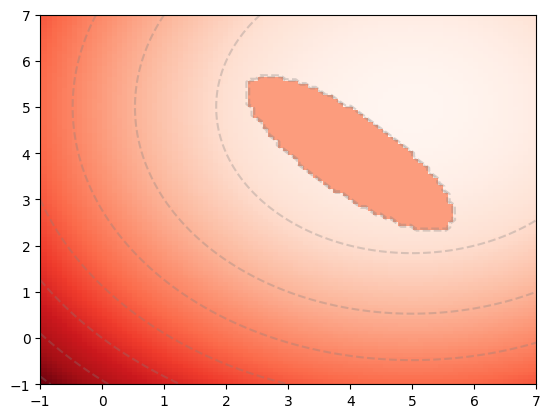

In [92]:
def reward_function(samples):
    target = np.array([5., 5.])
    obstacle = np.array([4., 4.])
    rewards = - ((samples - target)**2).sum(1)
    diff = samples - obstacle
    dist = ((diff @ np.array([[1, 0.8], [0.8, 1]]) ) * diff).sum(1)
    rewards[dist < 1] = - 25 
    return rewards

def reward_landscape(reward_func):
    x, y = np.meshgrid(np.linspace(-1, 7, 100), np.linspace(-1, 7, 100))
    x_coo, y_coo = x.flatten(), y.flatten()
    rewards = reward_func(np.stack([x_coo, y_coo]).T)
    
    plt.pcolor(x, y, rewards.reshape(*x.shape), cmap=plt.get_cmap("Reds_r"))
    plt.contour(x, y, rewards.reshape(*x.shape), colors='gray', alpha=0.3)
    plt.xlim([-1, 7])
    plt.ylim([-1, 7])

reward_landscape(reward_function)

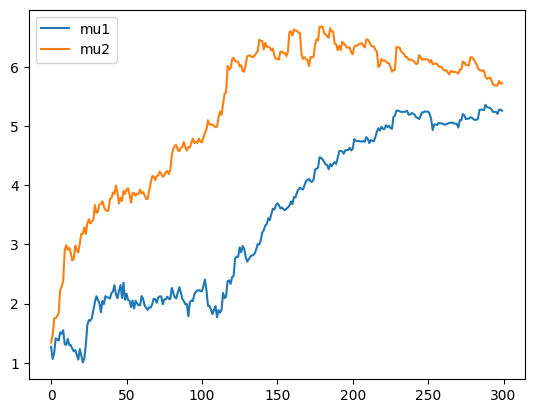

In [61]:
lr = 0.01
sampler = Sampler()

mus = []
for _ in range(300):
    samples = sampler.sample(3)
    rewards = reward_function(samples)
    grad_log_probs = sampler.grad_log_prob(samples)
    grad = np.mean(grad_log_probs * rewards[:, None], axis=0)

    sampler.mu = sampler.mu + lr * grad  #gradient_ascent
    mus.append(sampler.mu)
    

mu1, mu2 = np.stack(mus).T


plt.plot(mu1, label='mu1')
plt.plot(mu2, label='mu2')
plt.legend()
plt.show()

In [113]:
def plot(traces, grad_steps, mu, target):
    plt.figure(figsize=(5, 5))
    plt.title(f"Update: {i + 1}")    
    reward_landscape(reward_function)
    
    plt.plot(*traces.T, c='c', linewidth=0.8)
    
    for g in grad_steps:
        plt.arrow(*mu, *g, head_width=.1, head_length=.1, fc='k', ec='k')
        
    plt.scatter(*samples.T, s=10, marker='x')
    plt.scatter(*mu, c='c')
    
    plt.scatter(*target, c='y')
    plt.text(*target, "goal")
    plt.show()

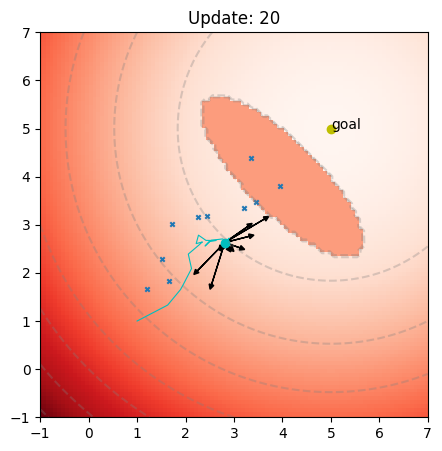

In [115]:
from IPython import display
import time

lr = 0.02
n_samples = 10
sampler = Sampler()
target = np.array([5., 5.])

traces = np.array([]).reshape(0, 2)

for i in range(20):
    samples = sampler.sample(n_samples)
    rewards = reward_function(samples)
    grad_log_probs = sampler.grad_log_prob(samples)
    grad_steps = lr * grad_log_probs * rewards[:, None]
    
    traces = np.concatenate([traces, sampler.mu[None, :]], axis=0)
    plot(traces, grad_steps, sampler.mu, target)

    sampler.mu = sampler.mu + np.mean(grad_steps, axis=0)  #gradient_ascent

    
    time.sleep(0.1)
    display.clear_output(wait=True)
